### This notebook contains solution of 2nd question

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from time import sleep

path = "/Users/adam/Documents/schneider/beeradvocate"

if path not in sys.path:
    sys.path.append(path)  # to enable import from modules

from modules.functions import pearson
from modules.functions import get_recs
from modules.functions import is_float

%matplotlib inline

In [3]:
dataset = pd.read_csv("../beer_reviews.csv")

In [4]:
dataset = dataset[["review_profilename", "beer_style", "review_overall"]]

In [5]:
dataset.head()

,review_profilename,beer_style,review_overall
0,stcules,Hefeweizen,1.5
1,stcules,English Strong Ale,3.0
2,stcules,Foreign / Export Stout,3.0
3,stcules,German Pilsener,3.0
4,johnmichaelsen,American Double / Imperial IPA,4.0


Create sparse pivot table

In [6]:
pivot_dataset = dataset.pivot_table(
    index=["review_profilename"], 
    columns=["beer_style"], 
    values="review_overall"
).astype(pd.SparseDtype("float", np.nan))

In [7]:
pivot_dataset.head()

beer_style,Altbier,American Adjunct Lager,American Amber / Red Ale,American Amber / Red Lager,American Barleywine,American Black Ale,American Blonde Ale,American Brown Ale,American Dark Wheat Ale,American Double / Imperial IPA,...,Scotch Ale / Wee Heavy,Scottish Ale,Scottish Gruit / Ancient Herbed Ale,Smoked Beer,Tripel,Vienna Lager,Weizenbock,Wheatwine,Winter Warmer,Witbier
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,4.0,NaN,3.25,5.0,4.5,4.5,NaN,4.3125,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.333333
01Ryan10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02maxima,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03SVTCobra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04101Brewer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(pivot_dataset.sparse.density)
print(sys.getsizeof(pivot_dataset))

0.11591942741417088
7036397


FInd out if some beers have a flat distribution (if yes, drop them before performing Pearson)

In [9]:
counter = 0

for col in pivot_dataset.columns:
    if (pivot_dataset[col] - pivot_dataset[col].mean()).sum() == 0:
        counter += 1
        
print(counter)

0


Find pairs with highest correlation

In [34]:
tmp = pd.DataFrame(pivot_dataset.corr(method='pearson').abs())
tmp.index.names = ["index"]  # to differentiate between the same column names
tmp = pd.DataFrame(tmp.unstack().sort_values(ascending=False)).reset_index(). \
    rename(columns={0: "abs correlation"})
tmp = tmp[tmp["beer_style"] != tmp["index"]]

In [35]:
tmp.head(10)  # how to get rid of "duplicated" rows?

,beer_style,index,abs correlation
104,Japanese Rice Lager,American Adjunct Lager,0.396985
105,American Adjunct Lager,Japanese Rice Lager,0.396985
106,Happoshu,Euro Pale Lager,0.389984
107,Euro Pale Lager,Happoshu,0.389984
108,Japanese Rice Lager,Euro Pale Lager,0.368928
109,Euro Pale Lager,Japanese Rice Lager,0.368928
110,Low Alcohol Beer,American Adjunct Lager,0.367644
111,American Adjunct Lager,Low Alcohol Beer,0.367644
112,Light Lager,American Adjunct Lager,0.359915
113,American Adjunct Lager,Light Lager,0.359915


Plot correlation heatmap

<function matplotlib.pyplot.show(close=None, block=None)>

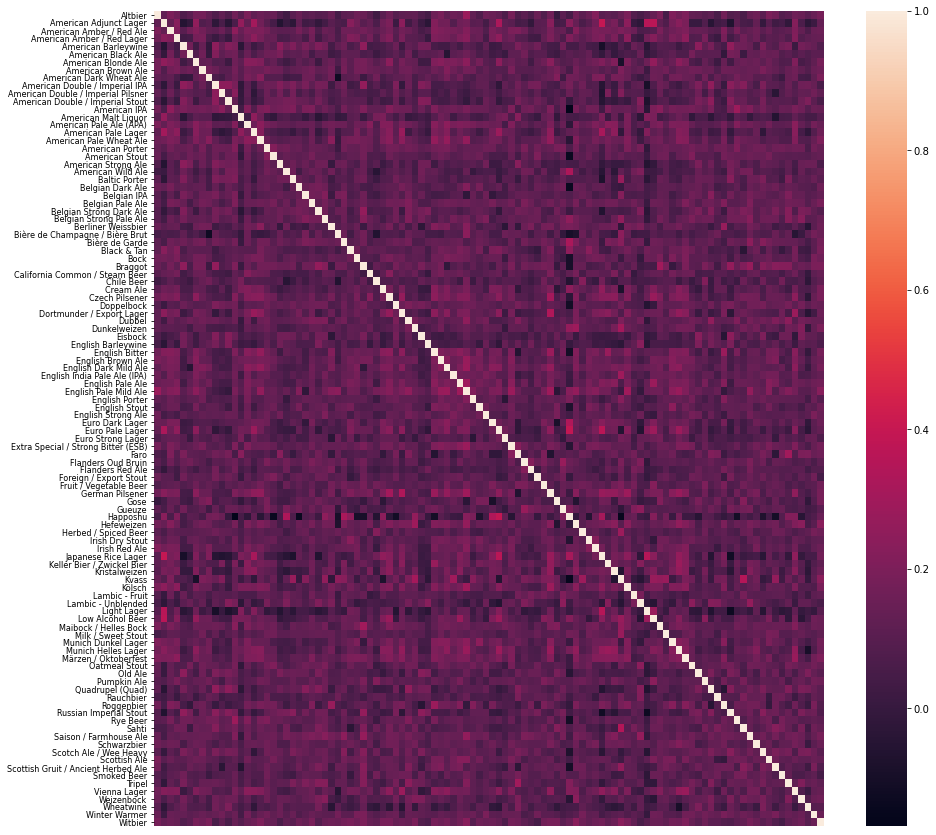

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(pivot_dataset.corr(method='pearson'), xticklabels=False, yticklabels=True)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=8)
plt.xlabel('')
plt.ylabel('')
plt.show

# 2nd question

Approach for top 3 beers recommendation:

1. Select all reviews (overall) for given user
1. Group them by beer style (proposal - mean aggregation)
1. Select top rated beers by this user (more than one beer can occur, i.e. NyackNicky user)
1. Use get_recs() to find 3 most correlated beers with every top rated beer for the user
1. Convert results into pd.DataFrame
1. Group correlations by beer (proposal - mean aggregation)
1. Sort DataFrame by correlation descending
1. Drop duplicates (keep first, which is most correlated)
1. Select top 3 beers from above DataFrame

### Version 1: select existing user in dataset

In [22]:
while True:
    try:
        print("Enter user name (type -1 to terminate):")  # example: NyackNicky
        sleep(1)  # without that prompt appears below textfield 
        profile = input()
        print("")
        
        if profile == "-1":
            print("Thank you for using program. Bye!")
            break

        tmp = dataset[dataset["review_profilename"] == profile]
        tmp = tmp.groupby(["beer_style"])["review_overall"].mean().reset_index()
        tmp = tmp[tmp["review_overall"] == tmp["review_overall"].max()]

        rec_list = []

        for beer in tmp["beer_style"].unique():
            rec_list.extend(get_recs(beer, pivot_dataset, num=3))

        top3 = pd.DataFrame(rec_list).groupby(0).mean().reset_index().sort_values(by=1, ascending=False). \
            reset_index(drop=True).drop_duplicates(subset=0).reset_index(drop=True).loc[:2, 0]

        print(f"Top 3 recommended beers for user {profile} are (descending order):")

        for i, item in enumerate(top3):
            print(f"{i+1}. {item}")
        print("")

    except KeyError:
        print(f"User {profile} not in database. Try again!")
        print("")

Enter user name (type -1 to terminate):
NyackNicky

Top 3 recommended beers for user NyackNicky are (descending order):
1. German Pilsener
2. Vienna Lager
3. Dortmunder / Export Lager

Enter user name (type -1 to terminate):
-1

Thank you for using program. Bye!


### Version 2: enter beer you like the most

In [33]:
while True:
    print("Enter beer you like the most (type -1 to terminate):")
    sleep(1)  # without that prompt apperas below textfield 
    beer = input()
    print("")
    
    if beer == "-1":
        print("Thank you for using program. Bye!")
        break

    if beer not in pivot_dataset.columns:
        print(f"Beer {beer} not in database. Try again!")
        print("")
        continue

    rec_list = get_recs(beer, pivot_dataset, num=3)

    top3 = pd.DataFrame(rec_list).sort_values(by=1, ascending=False).reset_index(drop=True).loc[:2, 0]

    print("Top 3 recommended beers for you are (descending order):")

    for i, item in enumerate(top3):
        print(f"{i+1}. {item}")
    print("")

Enter beer you like the most (type -1 to terminate):
Vienna Lager

Top 3 recommended beers for you are (descending order):
1. Märzen / Oktoberfest
2. Dortmunder / Export Lager
3. Munich Helles Lager

Enter beer you like the most (type -1 to terminate):
-1

Thank you for using program. Bye!


### Possible improvements

1. Consider using beer name with beer id instead of beer style
1. Let user add more beers and reviews (version 2)
1. If user gave no mean review above i.e. 4.0 for best rated beer by him, consider not recommending any beer
1. If correlations with best rated beer by user are too low (i.e. below 0.25), do not recommend any beer
1. Try to predict basing also on other features of review (not only overall)

In [ ]:
# may be useful in the future...

#     print("Enter your review for selected beer (from 0 to 5):")
#     sleep(1)  # without that prompt apperas below textfield 
#     review = input()
#     print("")
        
#     if not is_float(review) or (is_float(review) and not (0 <= float(review) <= 5)):
#         print(f"Number not in range (0, 5). Try again!")
#         print("")
#         continue